# Spiking CNN from NIR to SpiNNaker2

In this notebook we will show how a pre-trained Spiking CNN NIR model can be deployed onto the SpiNNaker2 chip.

py-spinnaker2, the high-level software interface for running spiking neural networks on SpiNNaker2, provides an API similar to PyNN and allows to define populations (groups of neurons with the same neuron model) and projections (group of synapses between two populations).

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt

# import norse
import numpy as np
import tonic
import torch
import tqdm
from spinnaker2 import brian2_sim, hardware, s2_nir, snn

import nir

class Args(object):
    pass
args = Args()


## Select to run either on Brian2 or on SpiNNaker2.
We can run the same network on the Brian2 simulator or on SpiNNaker2. Select one.

In [2]:
args.s2_ip = "brian2"        # use Brian2 Simulator
#args.s2_ip = "192.168.1.48"  # enter the IP of the SpiNNaker2 board
print(args.s2_ip)

brian2


## Load the NIR model from disk

In [3]:
model_path = "scnn_mnist.nir"
nir_graph = nir.read(model_path)

# make sure all nodes have necessary shape information
nir_graph.infer_types()
s2_nir.model_summary(nir_graph)

[warning] 4.input_type undefined, set to 3.output_type
[warning] 7.input_type undefined, set to 6.output_type
input <class 'nir.ir.Input'> {'input': array([ 2, 34, 34])} {'output': array([ 2, 34, 34])} -> ['0']
0 <class 'nir.ir.Conv2d'> {'input': array([ 2, 34, 34])} {'output': array([16, 16, 16])} -> ['1']
1 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['2']
2 <class 'nir.ir.Conv2d'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['3']
3 <class 'nir.ir.IF'> {'input': array([16, 16, 16])} {'output': array([16, 16, 16])} -> ['4']
4 <class 'nir.ir.SumPool2d'> {'input': array([16, 16, 16])} {'output': array([16,  8,  8])} -> ['5']
5 <class 'nir.ir.Conv2d'> {'input': array([16,  8,  8])} {'output': array([8, 8, 8])} -> ['6']
6 <class 'nir.ir.IF'> {'input': array([8, 8, 8])} {'output': array([8, 8, 8])} -> ['7']
7 <class 'nir.ir.SumPool2d'> {'input': array([8, 8, 8])} {'output': array([8, 4, 4])} -> ['8']
8 <class 'nir.ir.Flatten'>

If you want to record the output of intermediate IF neurons, use `s2_nir.add_output_to_node`. Only do this if you actually want to record because this will slow down the iterations significantly!

In [4]:
# Add an output to neurons of layer '1'
# s2_nir.add_output_to_node('1', nir_graph, '1_out')

## Convert NIR graph into py-spinnaker2 network
Converts the graph from NIR into a spinnaker2.snn.Network().
The ConversionConfig object gives several options specific to the py-spinnaker2 interface.
- The `output_record` configures what should be recorded at the network outputs: spikes `["spikes"]`, membrane potantials `["v"]` or both `["spikes", "v"]`.
- `dt`: integration time constant
- `conn_delay`: the connections between neurons can have a delay of multiples of `dt`

In [ ]:
# Configuration for converting NIR graph to SpiNNaker2
conversion_cfg = s2_nir.ConversionConfig()
conversion_cfg.output_record = ["spikes"]
conversion_cfg.dt = 0.0001
conversion_cfg.conn_delay = 0
conversion_cfg.scale_weights = True # Scale weights to dynamic range on chip
conversion_cfg.reset = s2_nir.ResetMethod.ZERO # Reset voltage to zero at spike
conversion_cfg.integrator = s2_nir.IntegratorMethod.FORWARD # Euler-Forward

net, inp, outp = s2_nir.from_nir(nir_graph, conversion_cfg)

### Customize neurons per core
Because of memory and compute time limitations per core, we need to reduce the number of neurons per core for some of the neuron populations:

In [6]:
max_atoms_per_core = {
    "3": 256,
    "6": 128,
    "10": 16
}
for pop in net.populations:
    if pop.name in max_atoms_per_core.keys():
        pop.set_max_atoms_per_core(max_atoms_per_core[pop.name])

# Evaluation on Neuromorphic MNIST
## Load the dataset

In [7]:
to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3
)
dataset = tonic.datasets.NMNIST(".", transform=to_frame, train=False)
loader = torch.utils.data.DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=tonic.collation.PadTensors(batch_first=False),
)

## Convert input data to spikes
While the torch dataset uses tensors, py-spinnaker2's input populations of type spike_list require spike times as input. Here's the conversion function that also considers flattening of the 3-dimensional frames.

In [8]:
def convert_input(x):
    print(x.shape)
    d = {}
    # T = x.shape[0]
    C = x.shape[2]
    H = x.shape[3]
    W = x.shape[4]
    for c in range(C):
        for h in range(H):
            for w in range(W):
                d[c * H * W + h * W + w] = x[:, 0, c, h, w].nonzero()[0].tolist()
    return d

## Setup of Hardware or Simulator Backend
If we use Brian2, we can now create the Backend, for SpiNNaker2 we have to do this for each iteration.

In [9]:
use_brian2 = args.s2_ip is None or args.s2_ip=="brian2"
if use_brian2:
    # brian2 backend can be reused
    hw = brian2_sim.Brian2Backend()
    print("\nUsing brian2 simulator!")
else:
     # S2 Hardware has to be created for each sample processed -> in loop
    print(f"\nUsing SpiNNaker2 at IP {args.s2_ip}")


Using brian2 simulator!


## Evaluation of a single sample
This is a function to evaluate one single sample of the dataset.

In [10]:
def evaluate(hw, net, inp, outp, x, y):
    input_spikes = convert_input(x)
    inp[0].params = input_spikes

    timesteps = x.shape[0] + 1
    net.reset()
    hw.run(net, timesteps, sys_tick_in_s=2.5e-3, debug=False)

    out_spikes = np.zeros(10)
    out_spike_times = outp[0].get_spikes()
    for idx, spikes in out_spike_times.items():
        # we are interested in spike rate, not count or exact times
        out_spikes[idx] = len(spikes) / x.shape[0]
    return np.argmax(out_spikes)

## Evaluating the complete dataset on SpiNNaker2 or Simulator
Iterates over the complete dataset and calles the evaluate() function from above. Warning: This will usually take several hours!

In [ ]:
predicted_spike = []
groundtruth = []
import sys
with torch.no_grad():
    for batch in tqdm.tqdm(loader, file=sys.stdout):
        x, y = batch
        x = x.detach().numpy()
        y = y.detach().numpy()
        print(" ")
        # We have to create S2 Chip connection
        if not use_brian2:
            hw = hardware.SpiNNaker2Chip(eth_ip=args.s2_ip)  # use ethernet
        pred_spike = evaluate(hw, net, inp, outp, x, y)

        # If we are using SpiNNaker2 chip, we have to delete the connection after use
        if not use_brian2:
            del hw
        predicted_spike.append(pred_spike)
        groundtruth.append(y[0])
        accuracy_spike = np.mean(np.array(predicted_spike) == np.array(groundtruth))
        print(f"Prediction:{pred_spike}, ground truth: {y[0]}")
        print(
            f"Current accuracy: {accuracy_spike:.4f}"
        )
print("\nFinished!\n")

final_accuracy = np.mean(np.array(predicted_spike) == np.array(groundtruth))

print(f"\nFinal accuracy: {final_accuracy:.4f}")
acc_file = "s2_brian2_accuracy.npy" if use_brian2 else "s2_accuracy.npy"
np.save(acc_file, final_accuracy)

# Activity
Now we want to get the activity output of the first IF layer, using a smaller dataset. In order to be able to extract the activity, we need to add an output to the net first.

We could use:
```
s2_nir.add_output_to_node('1', nir_graph, '1_out')
```
But then we would have to do a few of the other steps again. Instead, let us just modify the already converted net


In [17]:
outp = None
for pop in net.populations:
    if pop.name == "1":
        pop.record = ["v", "spikes"]
        outp = [pop]
        break
print("outp", outp[0].name, outp[0].record)

outp 1 ['v', 'spikes']


## Load the new data.

In [18]:
data = np.load("cnn_numbers.npy")
count = data.shape[1]
timesteps = data.shape[0]

## Define a new evaluate function

In [19]:
def evaluate(hw, net, inp, outp, x):
    input_spikes = convert_input(x)
    inp[0].params = input_spikes

    timesteps = x.shape[0] + 1
    net.reset()
    hw.run(net, timesteps, sys_tick_in_s=2.5e-3, debug=False)

    out_spike_times = outp[0].get_spikes()
    out_spikes = np.zeros((301, len(out_spike_times)))
    for idx, spikes in out_spike_times.items():
        # we are interested in spike rate, not count or exact times
        out_spikes[spikes, idx] = 1
        
    out_spikes = out_spikes.reshape((301,1,16,16,16))
    return out_spikes
    


## Iterate over new data

In [ ]:
all_spikes = np.zeros((301,10,16,16,16))
for i in range(count):
    x = data[:,i:i+1,...]
    
    if not use_brian2:
        hw = hardware.SpiNNaker2Chip(eth_ip=args.s2_ip)  # use ethernet
    
    pred_spike = evaluate(hw, net, inp, outp, x)

    # If we are using SpiNNaker2 chip, we have to delete the connection after use
    if not use_brian2:
        del hw
    all_spikes[:,i:i+1,...] = pred_spike

sim_name = "s2_brian2" if use_brian2 else "s2"
np.save(f"{sim_name}_corrected_activity.npy", all_spikes[1:,...])
np.save(f"{sim_name}_uncorrected_activity.npy", all_spikes[:-1,...])


## Visualization of the Activity of the first layer

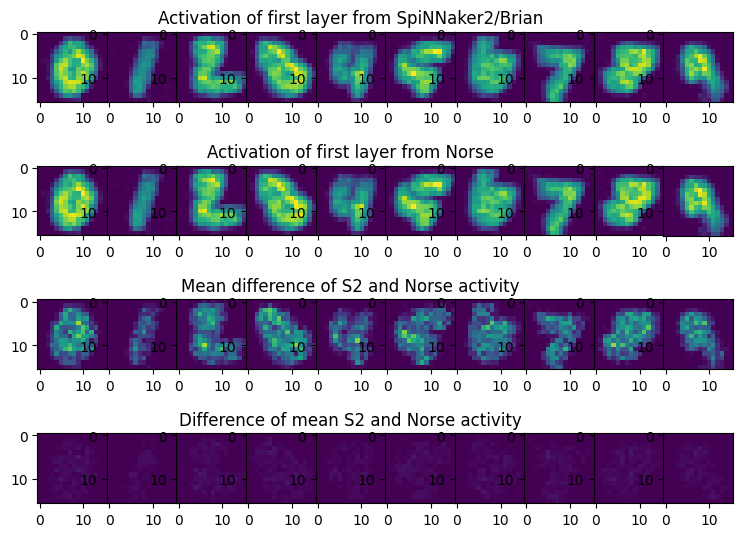

In [29]:
plt.ion()
fig, axs = plt.subplots(4,10)
norse_spikes = np.load("Norse_activity.npy")

s2 = np.mean(all_spikes[1:,...], axis=0)
s2 = np.mean(s2, axis=1)
n = np.mean(norse_spikes, axis=0)
n = np.mean(n, axis=1)
d = np.mean(np.abs(norse_spikes-all_spikes[1:,...]), axis=0)
d = np.mean(d, axis=1)
d2 = np.abs(s2-n)


axs[0,4].set_title("Activation of first layer from SpiNNaker2/Brian")
axs[1,4].set_title("Activation of first layer from Norse")
axs[2,4].set_title("Mean difference of S2 and Norse activity")
axs[3,4].set_title("Difference of mean S2 and Norse activity")
for idx in range(10):
    axs[0, idx].imshow(s2[idx,...], vmin=0, vmax=0.017)
    axs[1, idx].imshow(n[idx,...], vmin=0, vmax=0.017)
    axs[2, idx].imshow(d[idx,...], vmin=0, vmax=0.017)
    axs[3, idx].imshow(d2[idx,...], vmin=0, vmax=0.017)
plt.tight_layout(pad=-3, h_pad=-2,w_pad=-2)